#  🍰 Parameter subset training

The following example demonstrates how to train a subset of parameters. 


One approach is to split the parameters into two groups and train them separately, the set that is trainable and the set that is not trainable, then change the loss function signature from `loss_func(net, *args)` to 
`loss_func(trainable_net, non_trainable_net, *args)`, and use `jax` transformations on the new loss function to select only the trainable parameters via `argnums`. The problem with this approach is that it requires changing the loss function signature, which requires a rewrite of the loss function and all the functions that call it plus a function that splits the parameters into two groups.

`serket` adopts a different approach  that does not change the loss function signature. The idea is to use a pytree wrapper that hides un wanted parameters from tree input to the loss function. By doing so, selecting single parameters or groups of parameters to set untrainable becomes as simple as just wrapping them, instead of having to use `tree_map` to split the parameters into two groups and then rewrite the loss function.

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet

In [2]:
import serket as sk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

Before we continue with the example, let's first see how to wrap a parameter or a group of parameters using `serket.tree_mask`


In [3]:
# always returns a frozen tree by making the mask always True
mask = lambda node: sk.tree_mask(node, cond=lambda _: True)

tree = dict(a=1, b=mask(1.0))
print(jax.tree_util.tree_leaves(tree))  # -> b is excluded
print(jax.tree_util.tree_map(lambda x: x + 100, tree))  # only a is updated
# now lets unfreeze b by removing the mask
tree["b"] = sk.tree_unmask(tree["b"])
print(jax.tree_util.tree_leaves(tree))  # -> b is included
print(jax.tree_util.tree_map(lambda x: x + 100, tree))  # now b is updated

[1]
{'a': 101, 'b': #1.0}
[1, 1.0]
{'a': 101, 'b': 101.0}


First, full parameter training is demonstrated.

linear1.bias before training
[[ 0.49224907]
 [-0.5270041 ]
 [ 0.45504808]
 [-0.33848107]
 [ 0.077328  ]
 [-0.34419173]
 [-0.40663013]
 [ 0.5225283 ]
 [-0.36731058]
 [-0.05429043]]
linear2.bias before training
[[ 1.3350583  -0.8601161  -0.43461302 -0.126941    1.2539482   1.9338281
   0.8106119  -0.8920415  -1.8308382  -2.6761057 ]]
linear1.weight after training
[[ 0.5044241 ]
 [-0.563494  ]
 [ 0.9291068 ]
 [-0.32728744]
 [ 0.17630501]
 [-1.3267785 ]
 [-0.90045315]
 [ 1.3376606 ]
 [-0.41753185]
 [-0.22012907]]
linear2.weight after training
[[ 1.3854834  -0.8917768  -0.9622722  -0.12210654  1.2699867   2.4034626
   1.1609929  -1.6427257  -1.8600163  -2.6882136 ]]


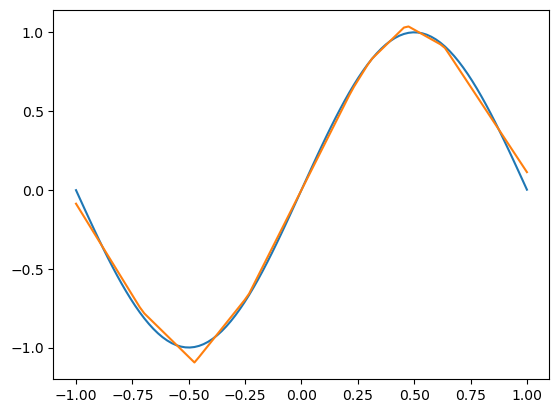

In [4]:
class Net(sk.TreeClass):
    def __init__(self, key):
        k1, k2 = jax.random.split(key, 2)
        self.linear1 = sk.nn.Linear(
            in_features=1,
            out_features=10,
            weight_init="he_normal",
            key=k1,
        )
        self.linear2 = sk.nn.Linear(
            in_features=10,
            out_features=1,
            weight_init="he_normal",
            key=k2,
        )

    def __call__(self, x):
        return self.linear2(jax.nn.relu(self.linear1(x)))


net = Net(key=jax.random.PRNGKey(0))
net = sk.tree_mask(net)
x = jnp.linspace(-1, 1, 100)[..., None]
y = jnp.sin(x * 3.14)


@jax.jit
def train_step(net: Net, x: jax.Array, y: jax.Array) -> Net:
    def loss_func(net, x, y):
        ypred = jax.vmap(sk.tree_unmask(net))(x)
        loss = jnp.mean((ypred - y) ** 2)
        return loss

    grad = jax.grad(loss_func)(net, x, y)
    net = jax.tree_util.tree_map(lambda p, g: p - 1e-2 * g, net, grad)
    return net


print("linear1.bias before training")
print(net.linear1.weight)
print("linear2.bias before training")
print(net.linear2.weight)

for i in range(10_000):
    net = train_step(net, x, y)
net = sk.tree_unmask(net)

plt.plot(x, y, label="true")
plt.plot(x, jax.vmap(net)(x), label="pred")

print("=" * 100)
print("linear1.weight after training")
print(net.linear1.weight)
print("linear2.weight after training")
print(net.linear2.weight)

Now, lets exclude `linear1.weight`, by simply applying `sk.tree_mask(..., lambda _:True)` on `linear1.weight` without changing anything else. 

linear1.weight before training
[[ 0.49224907]
 [-0.5270041 ]
 [ 0.45504808]
 [-0.33848107]
 [ 0.077328  ]
 [-0.34419173]
 [-0.40663013]
 [ 0.5225283 ]
 [-0.36731058]
 [-0.05429043]]
linear2.bias before training
[[ 1.3350583  -0.8601161  -0.43461302 -0.126941    1.2539482   1.9338281
   0.8106119  -0.8920415  -1.8308382  -2.6761057 ]]
linear1.weight after training
[[ 0.49224907]
 [-0.5270041 ]
 [ 0.45504808]
 [-0.33848107]
 [ 0.077328  ]
 [-0.34419173]
 [-0.40663013]
 [ 0.5225283 ]
 [-0.36731058]
 [-0.05429043]]
linear2.weight after training
[[ 1.6160113  -0.8494978  -1.457918    0.49293038  1.3003088   2.8833866
   1.9283234  -2.0790174  -1.8294331  -2.6764386 ]]


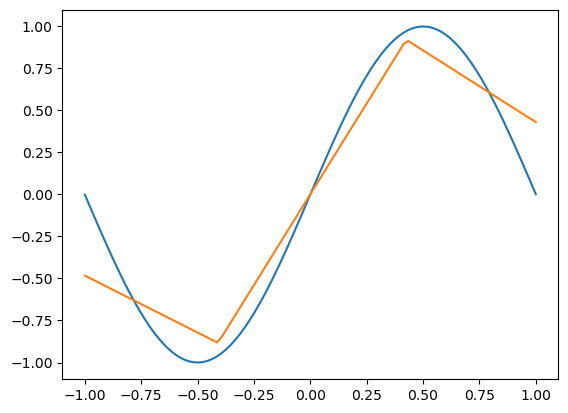

In [5]:
net = Net(key=jax.random.PRNGKey(0))
net = sk.tree_mask(net)

print("linear1.weight before training")
print(net.linear1.weight)
print("linear2.bias before training")
print(net.linear2.weight)

# exclude `linear1` by freezing it (wrapping by leafless pytree wrapper)
net = net.at["linear1"]["weight"].apply(mask)

for i in range(10_000):
    net = train_step(net, x, y)

net = sk.tree_unmask(net)
plt.plot(x, y, label="true")
plt.plot(x, jax.vmap(net)(x), label="pred")

print("=" * 100)
print("linear1.weight after training")
print(net.linear1.weight)
print("linear2.weight after training")
print(net.linear2.weight)

Another possibility is that we can freeze/unfreeze based on a condition. For example, we can start by training full parameters and then later on we can optimize the layers near the head.